[Expt/trainable-forgetting-decay](https://github.com/open-spaced-repetition/fsrs-optimizer/tree/Expt/trainable-forgetting-decay)

In [1]:
import numpy as np
import pandas as pd
import os
import sys

sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    1.1596,
    1.7974,
    13.1205,
    49.3729,
    7.2303,
    0.5081,
    1.5371,
    0.0010,
    1.5052,
    0.1261,
    0.9735,
    1.8924,
    0.1486,
    0.2407,
    2.1937,
    0.1518,
    3.0699,
    0,
    0,
    0.5
]


def generate_revlog_from_simulation(initial_parameters, learn_span):
    _, _, _, _, _, revlogs = simulate(
        w=initial_parameters,
        learn_span=learn_span,
        first_rating_offset=np.array([0, 0, 0, 0]),
        first_session_len=np.array([0, 0, 0, 0]),
        forget_rating_offset=0,
        forget_session_len=0,
        fuzz=True,
    )

    flattened_revlogs = []

    for day in revlogs:
        card_ids = revlogs[day]["card_id"]
        ratings = revlogs[day]["rating"]
        for card_id, rating in zip(card_ids, ratings):
            flattened_revlogs.append(
                {"card_id": card_id, "review_rating": int(rating), "day": day}
            )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt

decay_list = []

def train_and_evaluate(df):
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer(enable_short_term=False)
    optimizer.S0_dataset_group = (
        df[df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=df, verbose=False)
    optimizer.train(gamma=0, verbose=False)
    print(optimizer.w)
    decay_list.append(optimizer.w[19])
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, optimizer.w):
        if param == 0 and trained_param == 0:
            continue
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset

def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 30


sample size: 2223


  0%|          | 0/2223 [00:00<?, ?it/s]

[1.2028, 2.7132, 9.2016, 26.042, 7.2834, 0.688, 1.4224, 0.0732, 1.4604, 0.202, 0.941, 1.8707, 0.1844, 0.2433, 2.1643, 0.1248, 2.8028, 0.0, 0.0, 0.374]
loss before: 0.3609, loss after: 0.3364
RMSE(bins): 0.0306
AUC: 0.5986
1.1596 -> 1.2028: SMAPE=3.6573%
1.7974 -> 2.7132: SMAPE=40.6066%
13.1205 -> 9.2016: SMAPE=35.1123%
49.3729 -> 26.042: SMAPE=61.8734%
7.2303 -> 7.2834: SMAPE=0.7317%
0.5081 -> 0.688: SMAPE=30.0811%
1.5371 -> 1.4224: SMAPE=7.7513%
0.001 -> 0.0732: SMAPE=194.6092%
1.5052 -> 1.4604: SMAPE=3.0213%
0.1261 -> 0.202: SMAPE=46.2664%
0.9735 -> 0.941: SMAPE=3.3951%
1.8924 -> 1.8707: SMAPE=1.1533%
0.1486 -> 0.1844: SMAPE=21.5015%
0.2407 -> 0.2433: SMAPE=1.0744%
2.1937 -> 2.1643: SMAPE=1.3492%
0.1518 -> 0.1248: SMAPE=19.5228%
3.0699 -> 2.8028: SMAPE=9.0963%
0.5 -> 0.374: SMAPE=28.8330%
Avg. SMAPE: 28.3131%
loss before: 0.3609, loss after: 0.3384
RMSE(bins): 0.0329
AUC: 0.5742
--------------------------------
learn_span: 60


sample size: 5325


  0%|          | 0/5325 [00:00<?, ?it/s]

[1.0867, 1.5955, 12.5981, 35.7758, 7.1303, 0.6192, 1.4517, 0.0042, 1.6034, 0.5421, 1.1015, 1.8909, 0.1374, 0.2292, 2.3311, 0.0, 3.0883, 0.0, 0.0, 0.1215]
loss before: 0.3586, loss after: 0.3325
RMSE(bins): 0.0236
AUC: 0.5684
1.1596 -> 1.0867: SMAPE=6.4907%
1.7974 -> 1.5955: SMAPE=11.9013%
13.1205 -> 12.5981: SMAPE=4.0624%
49.3729 -> 35.7758: SMAPE=31.9373%
7.2303 -> 7.1303: SMAPE=1.3927%
0.5081 -> 0.6192: SMAPE=19.7108%
1.5371 -> 1.4517: SMAPE=5.7147%
0.001 -> 0.0042: SMAPE=123.0769%
1.5052 -> 1.6034: SMAPE=6.3180%
0.1261 -> 0.5421: SMAPE=124.5136%
0.9735 -> 1.1015: SMAPE=12.3373%
1.8924 -> 1.8909: SMAPE=0.0793%
0.1486 -> 0.1374: SMAPE=7.8322%
0.2407 -> 0.2292: SMAPE=4.8947%
2.1937 -> 2.3311: SMAPE=6.0732%
0.1518 -> 0.0: SMAPE=200.0000%
3.0699 -> 3.0883: SMAPE=0.5976%
0.5 -> 0.1215: SMAPE=121.8021%
Avg. SMAPE: 38.2630%
loss before: 0.3586, loss after: 0.3343
RMSE(bins): 0.0257
AUC: 0.5460
--------------------------------
learn_span: 120


sample size: 11740


  0%|          | 0/11740 [00:00<?, ?it/s]

[1.1875, 1.6228, 13.0838, 34.2093, 7.1116, 0.4856, 1.835, 0.0525, 1.5095, 0.3399, 1.018, 1.8137, 0.2368, 0.2196, 2.1755, 0.0845, 3.0218, 0.0, 0.0, 0.0824]
loss before: 0.3585, loss after: 0.3371
RMSE(bins): 0.0215
AUC: 0.5685
1.1596 -> 1.1875: SMAPE=2.3774%
1.7974 -> 1.6228: SMAPE=10.2099%
13.1205 -> 13.0838: SMAPE=0.2801%
49.3729 -> 34.2093: SMAPE=36.2843%
7.2303 -> 7.1116: SMAPE=1.6553%
0.5081 -> 0.4856: SMAPE=4.5285%
1.5371 -> 1.835: SMAPE=17.6685%
0.001 -> 0.0525: SMAPE=192.5234%
1.5052 -> 1.5095: SMAPE=0.2853%
0.1261 -> 0.3399: SMAPE=91.7597%
0.9735 -> 1.018: SMAPE=4.4690%
1.8924 -> 1.8137: SMAPE=4.2471%
0.1486 -> 0.2368: SMAPE=45.7706%
0.2407 -> 0.2196: SMAPE=9.1679%
2.1937 -> 2.1755: SMAPE=0.8331%
0.1518 -> 0.0845: SMAPE=56.9615%
3.0699 -> 3.0218: SMAPE=1.5792%
0.5 -> 0.0824: SMAPE=143.4066%
Avg. SMAPE: 34.6671%
loss before: 0.3585, loss after: 0.3374
RMSE(bins): 0.0200
AUC: 0.5721
--------------------------------
learn_span: 240


sample size: 25558


  0%|          | 0/25558 [00:00<?, ?it/s]

[1.0316, 1.7236, 13.8904, 49.1623, 7.0178, 0.4109, 1.9169, 0.001, 1.628, 0.3056, 1.1525, 1.7452, 0.2143, 0.2794, 2.1349, 0.1478, 3.1913, 0.0, 0.0, 0.1753]
loss before: 0.3486, loss after: 0.3315
RMSE(bins): 0.0165
AUC: 0.5652
1.1596 -> 1.0316: SMAPE=11.6831%
1.7974 -> 1.7236: SMAPE=4.1920%
13.1205 -> 13.8904: SMAPE=5.7007%
49.3729 -> 49.1623: SMAPE=0.4275%
7.2303 -> 7.0178: SMAPE=2.9829%
0.5081 -> 0.4109: SMAPE=21.1534%
1.5371 -> 1.9169: SMAPE=21.9919%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.628: SMAPE=7.8386%
0.1261 -> 0.3056: SMAPE=83.1596%
0.9735 -> 1.1525: SMAPE=16.8391%
1.8924 -> 1.7452: SMAPE=8.0932%
0.1486 -> 0.2143: SMAPE=36.2083%
0.2407 -> 0.2794: SMAPE=14.8818%
2.1937 -> 2.1349: SMAPE=2.7168%
0.1518 -> 0.1478: SMAPE=2.6702%
3.0699 -> 3.1913: SMAPE=3.8779%
0.5 -> 0.1753: SMAPE=96.1647%
Avg. SMAPE: 18.9212%
loss before: 0.3486, loss after: 0.3317
RMSE(bins): 0.0168
AUC: 0.5649
--------------------------------
learn_span: 480


sample size: 54050


  0%|          | 0/54050 [00:00<?, ?it/s]

[1.1088, 1.7623, 14.2932, 45.6342, 7.02, 0.4749, 1.4861, 0.001, 1.4343, 0.1685, 1.0488, 1.703, 0.2277, 0.2699, 2.3766, 0.1732, 2.8595, 0.0, 0.0, 0.2461]
loss before: 0.3483, loss after: 0.3340
RMSE(bins): 0.0127
AUC: 0.5607
1.1596 -> 1.1088: SMAPE=4.4789%
1.7974 -> 1.7623: SMAPE=1.9721%
13.1205 -> 14.2932: SMAPE=8.5556%
49.3729 -> 45.6342: SMAPE=7.8704%
7.2303 -> 7.02: SMAPE=2.9515%
0.5081 -> 0.4749: SMAPE=6.7548%
1.5371 -> 1.4861: SMAPE=3.3739%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.4343: SMAPE=4.8239%
0.1261 -> 0.1685: SMAPE=28.7848%
0.9735 -> 1.0488: SMAPE=7.4470%
1.8924 -> 1.703: SMAPE=10.5357%
0.1486 -> 0.2277: SMAPE=42.0409%
0.2407 -> 0.2699: SMAPE=11.4375%
2.1937 -> 2.3766: SMAPE=8.0039%
0.1518 -> 0.1732: SMAPE=13.1692%
3.0699 -> 2.8595: SMAPE=7.0968%
0.5 -> 0.2461: SMAPE=68.0606%
Avg. SMAPE: 13.1865%
loss before: 0.3483, loss after: 0.3340
RMSE(bins): 0.0126
AUC: 0.5602
--------------------------------
learn_span: 960


sample size: 103355


  0%|          | 0/103355 [00:00<?, ?it/s]

[1.1844, 1.6805, 13.0805, 48.6341, 7.0386, 0.4464, 1.7414, 0.003, 1.5091, 0.2091, 1.2205, 1.3737, 0.2038, 0.3022, 1.8734, 0.1461, 2.9476, 0.0, 0.0, 0.1257]
loss before: 0.3408, loss after: 0.3302
RMSE(bins): 0.0119
AUC: 0.5475
1.1596 -> 1.1844: SMAPE=2.1160%
1.7974 -> 1.6805: SMAPE=6.7224%
13.1205 -> 13.0805: SMAPE=0.3053%
49.3729 -> 48.6341: SMAPE=1.5076%
7.2303 -> 7.0386: SMAPE=2.6870%
0.5081 -> 0.4464: SMAPE=12.9282%
1.5371 -> 1.7414: SMAPE=12.4630%
0.001 -> 0.003: SMAPE=100.0000%
1.5052 -> 1.5091: SMAPE=0.2588%
0.1261 -> 0.2091: SMAPE=49.5227%
0.9735 -> 1.2205: SMAPE=22.5160%
1.8924 -> 1.3737: SMAPE=31.7627%
0.1486 -> 0.2038: SMAPE=31.3280%
0.2407 -> 0.3022: SMAPE=22.6561%
2.1937 -> 1.8734: SMAPE=15.7508%
0.1518 -> 0.1461: SMAPE=3.8268%
3.0699 -> 2.9476: SMAPE=4.0648%
0.5 -> 0.1257: SMAPE=119.6420%
Avg. SMAPE: 24.4477%
loss before: 0.3408, loss after: 0.3301
RMSE(bins): 0.0105
AUC: 0.5534
--------------------------------


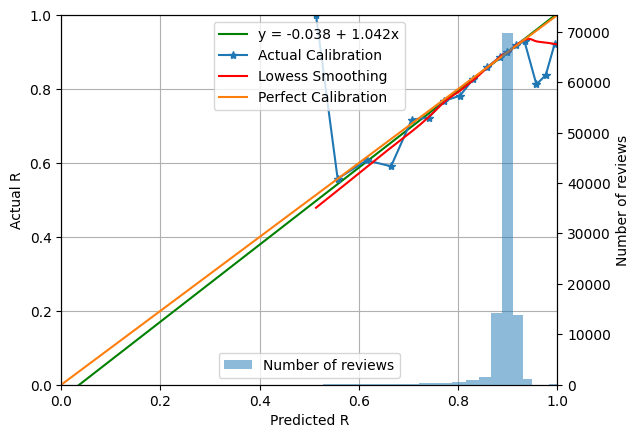

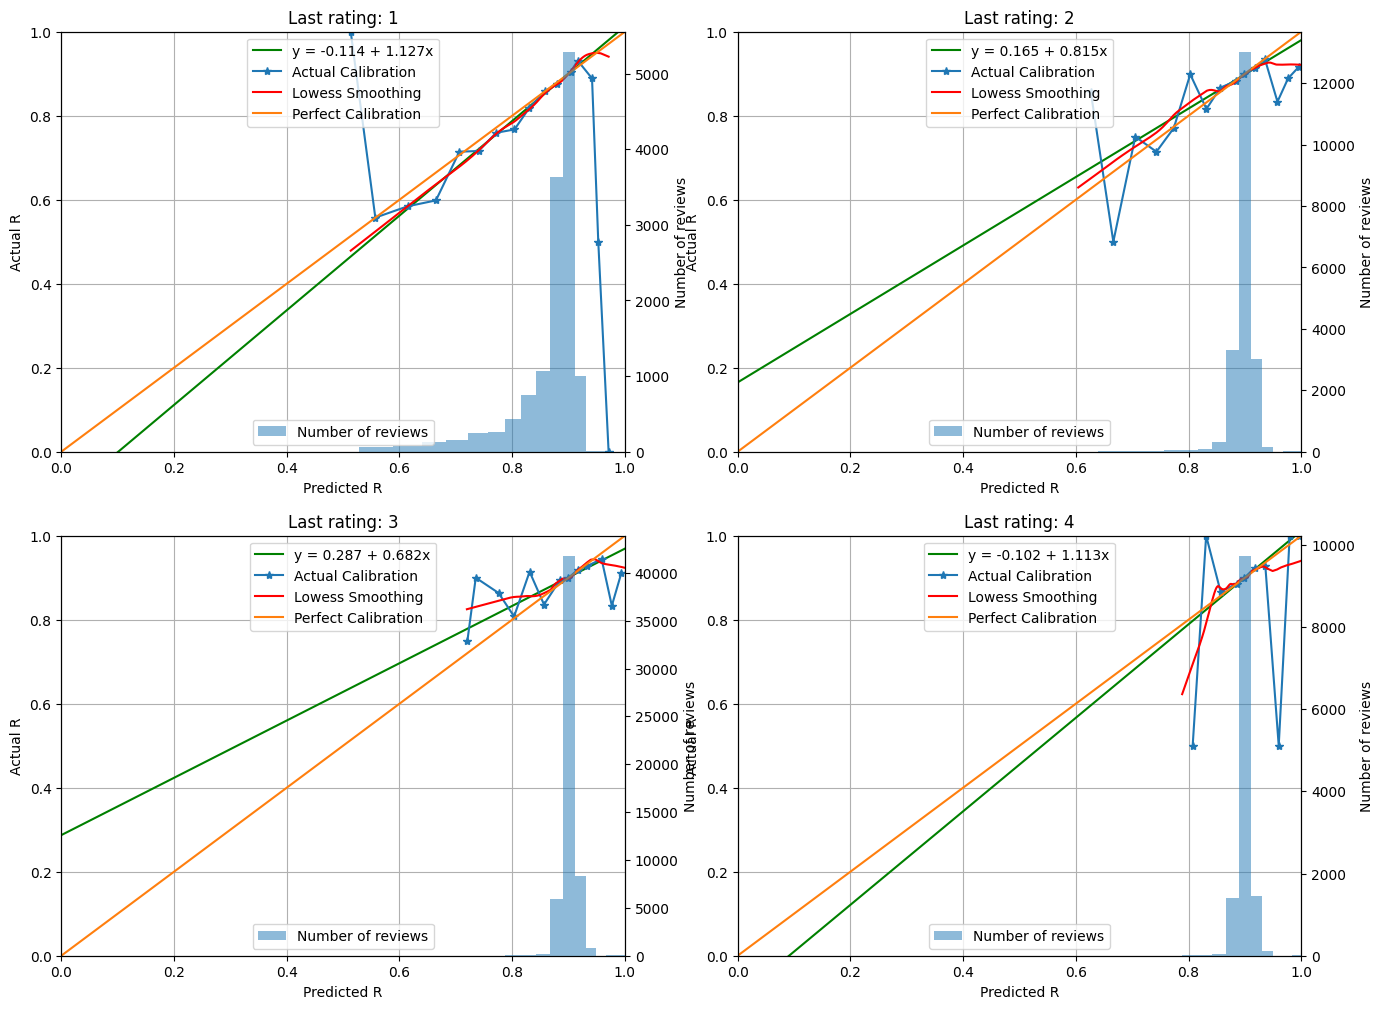

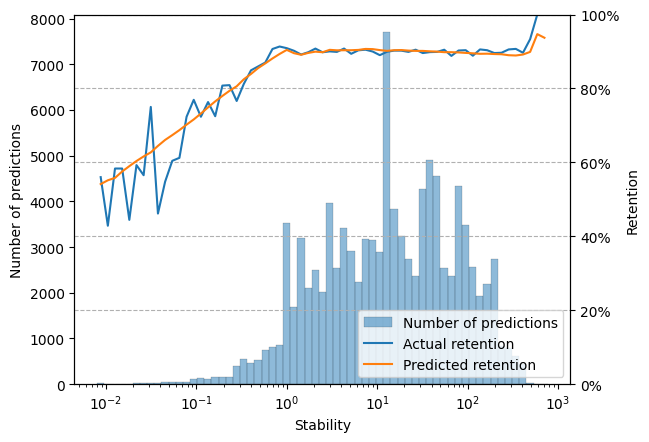

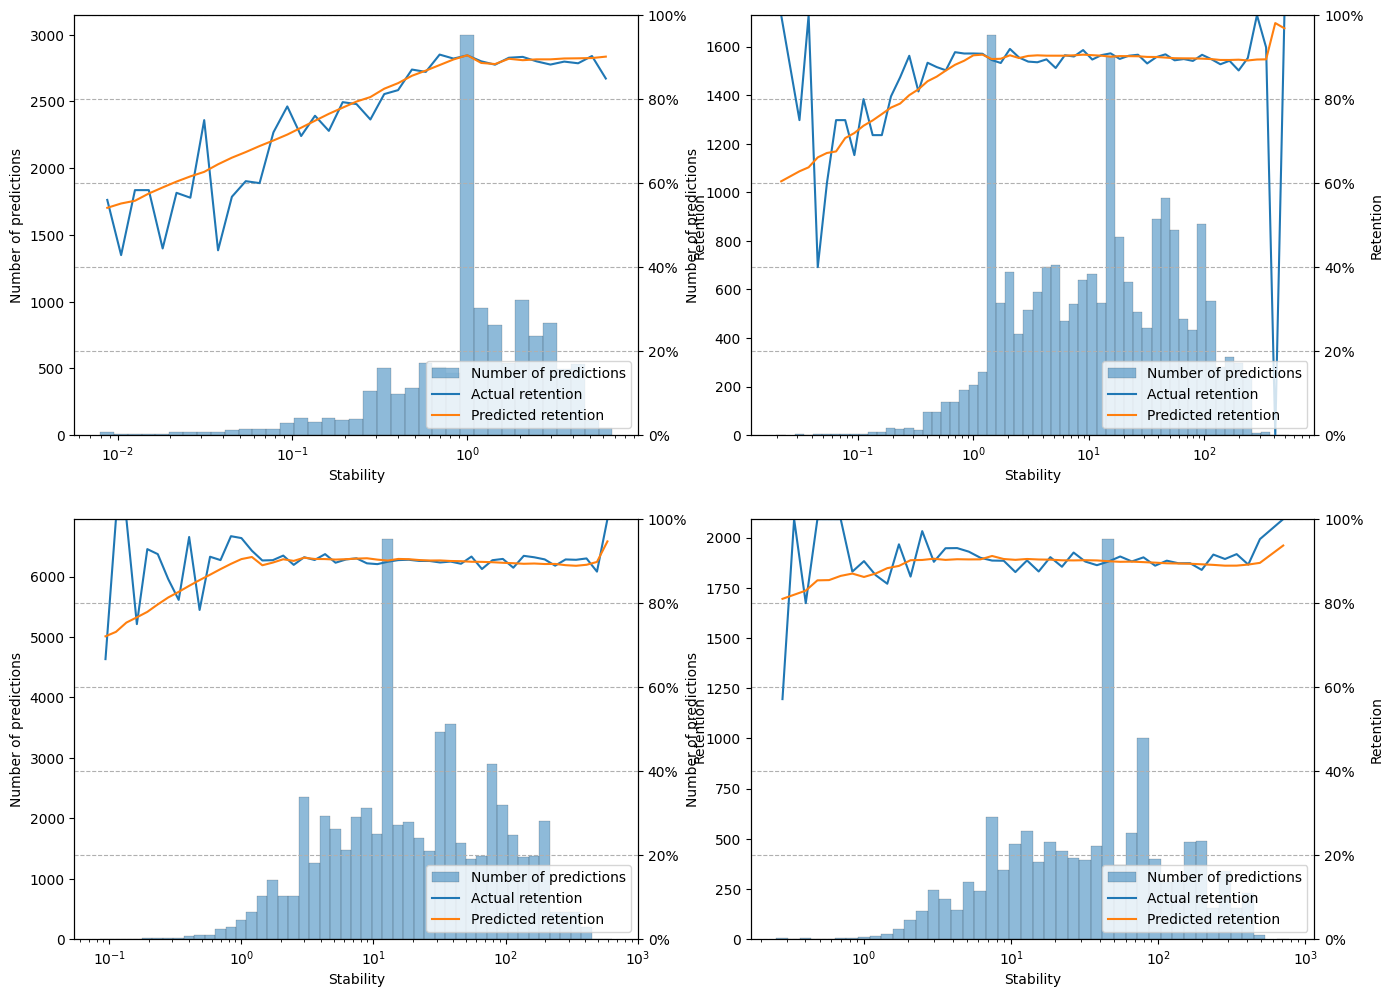

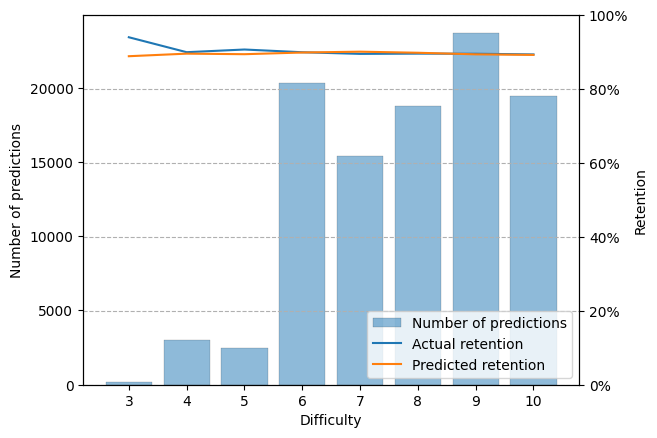

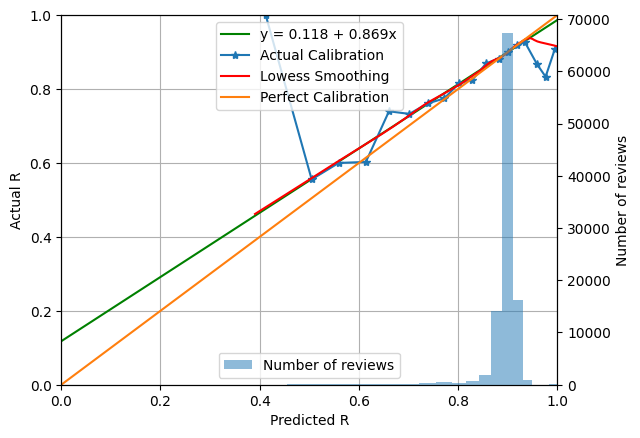

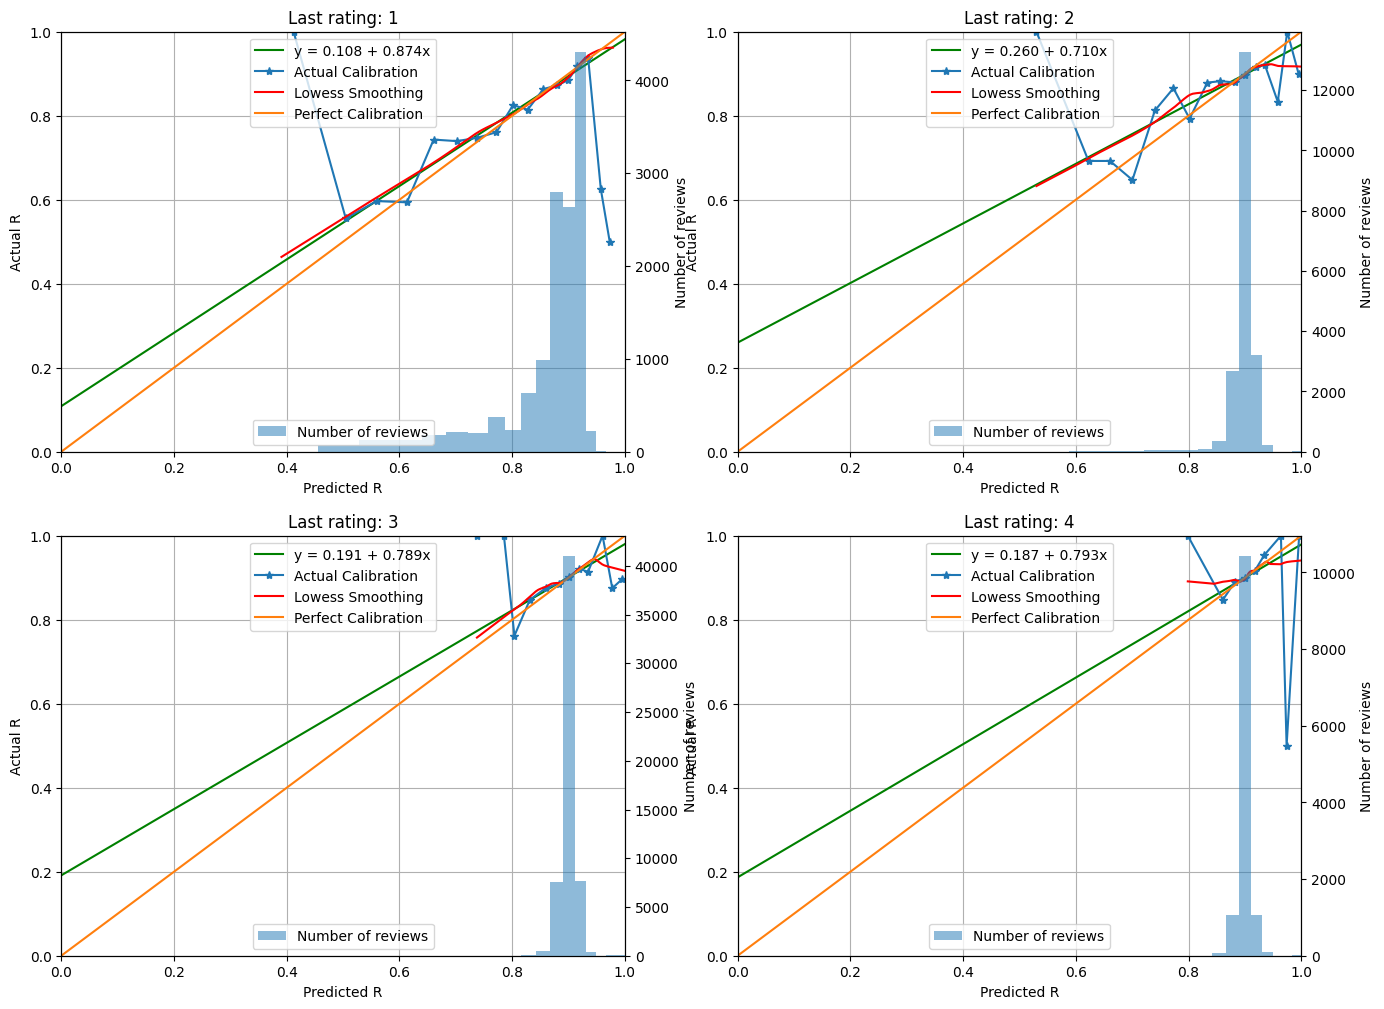

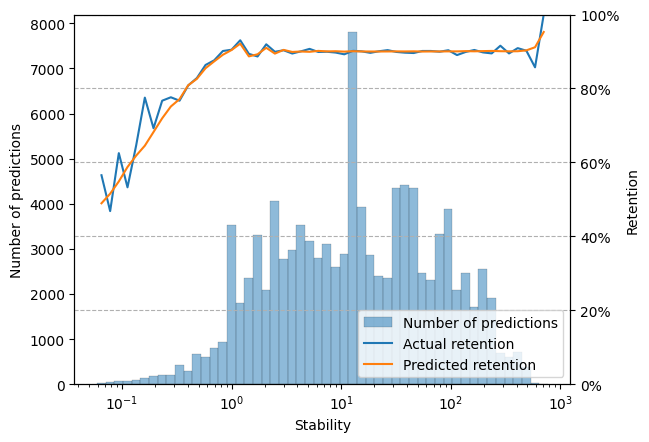

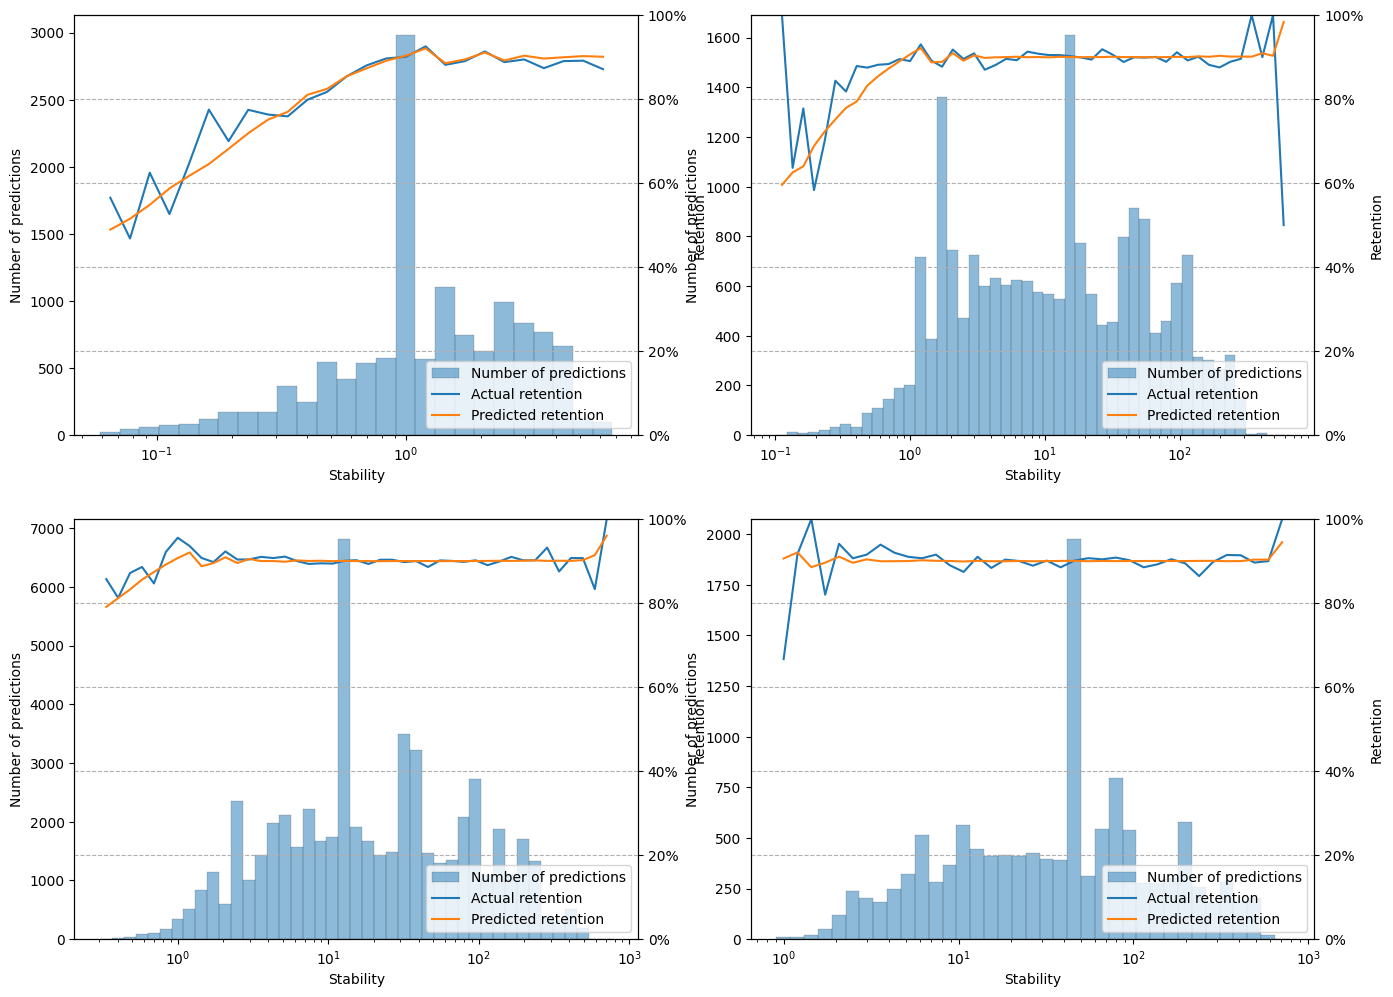

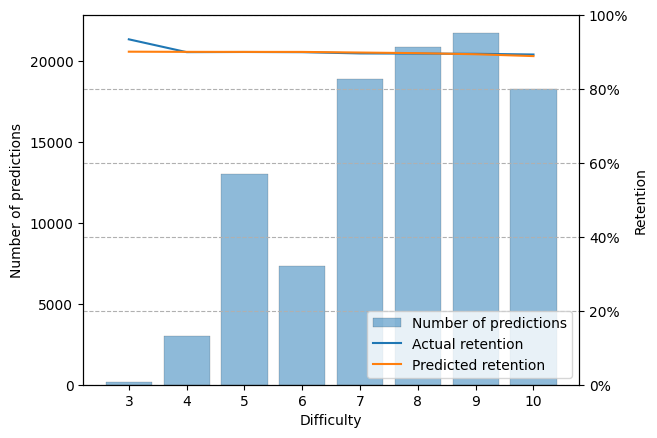

In [4]:
learn_span_list = [30, 60, 120, 240, 480, 960]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(initial_parameters, learn_span=learn_span)
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

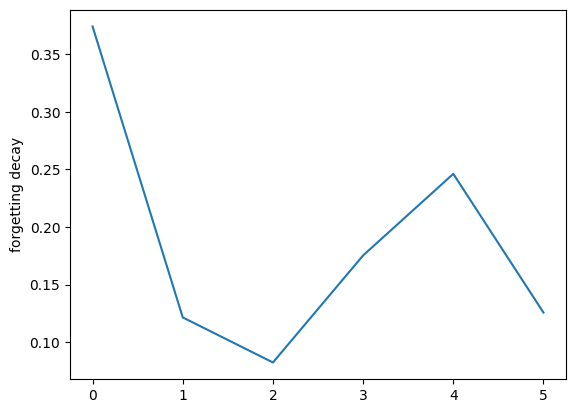

In [5]:
plt.plot(decay_list)
plt.ylabel("forgetting decay")
plt.show()

In [6]:
np.set_printoptions(precision=6, suppress=True)
print(f"logloss (trained - ideal): {np.array(logloss_list) - np.array(ideal_logloss_list)}")
print(f"RMSE(bins) (trained - ideal): {np.array(rmse_list) - np.array(ideal_rmse_list)}")
print(f"AUC (trained - ideal): {np.array(auc_list) - np.array(ideal_auc_list)}")

logloss (trained - ideal): [-0.002009 -0.001782 -0.000275 -0.000248 -0.000043  0.000081]
RMSE(bins) (trained - ideal): [-0.002347 -0.002123  0.001538 -0.000319  0.000077  0.001363]
AUC (trained - ideal): [ 0.024399  0.02231  -0.003593  0.000266  0.000471 -0.005877]


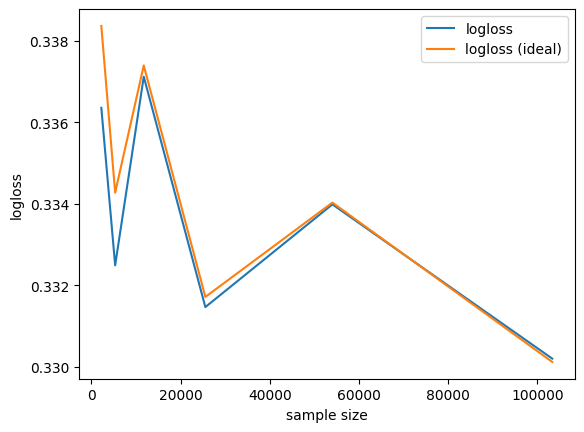

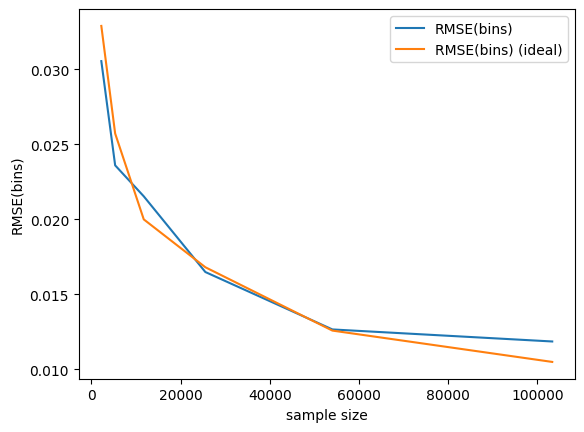

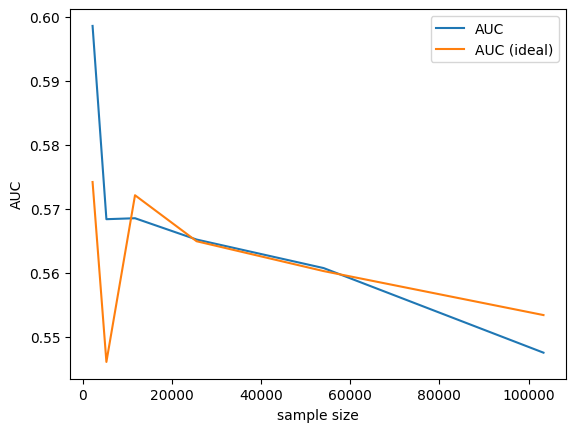

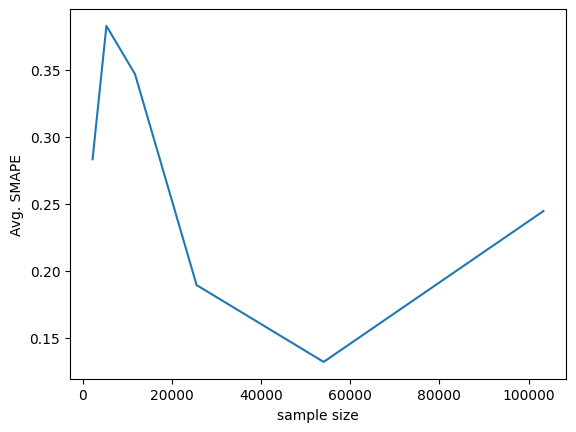

In [7]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()
